## Toxic: Preprocessing and K-Means Clustering / T-SNE

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.pipeline import Pipeline

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from wordcloud import WordCloud, STOPWORDS
from sklearn.manifold import TSNE

from time import time
import math

In [4]:
df = pd.read_pickle('../data/toxictrain.pkl')
print(df.shape)
# df.head()

(159571, 30)


### Assumptions

In [5]:
df_t = df[df['rating']>0]
df_nt = df[df['rating']==0]
print(df_t.shape)

seed = 42

(16225, 30)


In [6]:
# Code inspired by https://github.com/ailchau/Metis_Projects/blob/master/wrangling_with_restaurant_reviews/wrangling_with_restaurant_reviews.ipynb
def reduce_dimension(data,n_clusters):
    # Dimensionality Reduction
    tfidf = TfidfVectorizer(min_df=0.0001)
    X = tfidf.fit_transform(data)
#     word_list = tfidf.get_feature_names()
    nmf = NMF(n_components=n_clusters, random_state=seed, alpha=.1, l1_ratio=.5, init='nndsvd')
    X_reduced = nmf.fit_transform(X)
#     components = nmf.components_
#     for index,values in enumerate(components):
#         print("topic {}".format(index))
#         temp = list(zip(word_list, components[index]))
#         print(sorted(temp, key=lambda x: x[1], reverse=True)[:20],"\n")
    
    return X_reduced

def plot_kmc(X_reduced, n_clusters,tag):
    # plot K Means Clusters Silhouette and Clusters Analysis
    ns = np.arange(2, 20, 1)
    inertias = []
    silhouettes = []
    for n in ns:
        kmeans = KMeans(n_clusters=n, init="k-means++", random_state=seed).fit(X_reduced)
        inertias.append(kmeans.inertia_)
        labels = kmeans.labels_
        silhouettes.append(silhouette_score(X_reduced, labels, metric='euclidean',sample_size=5000))
        
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(2,2,1)
    # plot the inertia scores and look for the kink in the curve
    plt.plot(ns, inertias)
    plt.xlabel('Clusters')
    plt.ylabel('SSE')
    plt.title('Inertia: ' + tag)

    ax = fig.add_subplot(2,2,2)
    # plot the silhouettte scores
    plt.plot(ns, silhouettes)
    plt.xlabel('Clusters')
    plt.ylabel('Silhouette Coefficient')
    plt.title('Silhouette Scores: ' + tag)

    plt.tight_layout()
    filepath1 = "../charts/kmc_" + tag + ".png"
    plt.savefig(filepath1)
    print("KMC saved at " + filepath1)
    
    kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=seed)
    kmf = kmeans.fit(X_reduced)
    labels = kmf.labels_
    
    print("Inertia score: {}".format(kmf.inertia_))
    print("Silhouette score: {}".format(silhouette_score(X_reduced, labels, metric='euclidean', 
                                                         sample_size=5000, random_state=seed)))
    for cluster in range(len(set(labels))):
        print("Cluster {} has {} comments.".format(cluster, sum(labels==cluster))) 
        
    return X_reduced, labels

def create_wordcloud(text,width,height,max_words,title):
    wordcloud = WordCloud(stopwords=STOPWORDS, width=width,height=height,max_words=max_words).generate(text)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title,fontweight='bold',fontsize=16)

def wordcloud_visualizations(data,X_reduced,comments,labels,n_clusters,ncols,tag):
    cluster_map = pd.DataFrame(X_reduced)
    cluster_map['comments'] = [r for r in data]
    cluster_map['cluster'] = labels
    
    fig = plt.figure(figsize=(30,10))
    ncols = ncols
    nrows = math.ceil(n_clusters / ncols)
    plt.tight_layout()

    for i in range(n_clusters):
        ax = fig.add_subplot(nrows,ncols,i+1)
        cluster = ''.join(cluster_map[cluster_map.cluster==i].comments)
        create_wordcloud(cluster,400,200,100,'{} Cluster {}'.format(tag,i))
    filepath3 = "../charts/wc_kmctsne_" + tag + ".png"
    print("WordClouds saved at " + filepath3)
    plt.savefig(filepath3)
        
def plot_tsne(X_reduced, labels,tag):
    tsne = TSNE(n_components=2, perplexity=40, n_iter=500, random_state=seed)
    tsne = tsne.fit_transform(X_reduced)
    df_tsne = pd.DataFrame(tsne, columns=["tsne_x", "tsne_y"])
    df_tsne["Cluster"] = labels
    
    tsne = sns.lmplot("tsne_x", "tsne_y", data=df_tsne, fit_reg=False, hue="Cluster")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title( tag + " Clusters",fontweight='bold')
    filepath2 = "../charts/tsne_" + tag + ".png"
    plt.savefig(filepath2)
    print("T-SNE saved at " + filepath2)
    
def create_kmc_tsne(data, n_clusters, seed, ncols,tag):
    # wrapper function
    X_reduced, labels = plot_kmc(reduce_dimension(data,n_clusters),n_clusters,tag)
    wordcloud_visualizations(X_reduced,data,labels,n_clusters,ncols,tag)
    plot_tsne(X_reduced,labels,tag)

KMC saved at ../charts/kmc_Toxic.png
Inertia score: 4.791764856306167
Silhouette score: 0.6050876052031419
Cluster 0 has 13216 comments.
Cluster 1 has 872 comments.
Cluster 2 has 903 comments.
Cluster 3 has 463 comments.
Cluster 4 has 454 comments.
Cluster 5 has 317 comments.
WordClouds saved at ../charts/wc_kmctsne_Toxic.png
T-SNE saved at ../charts/tsne_Toxic.png


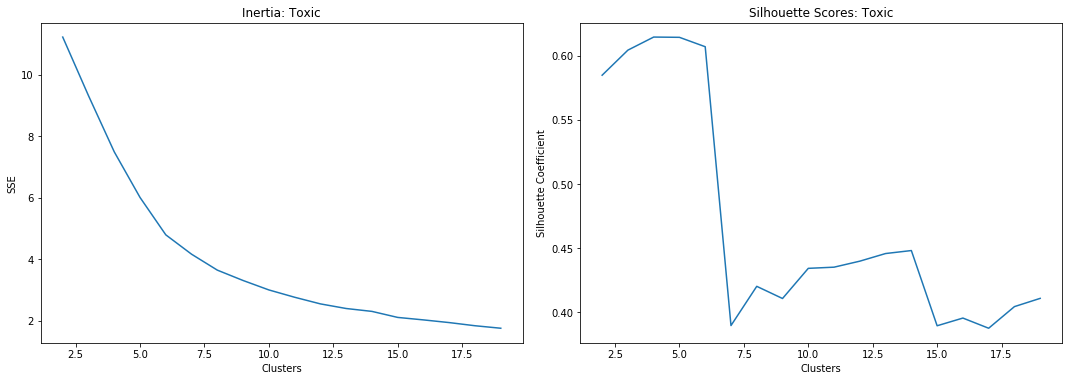

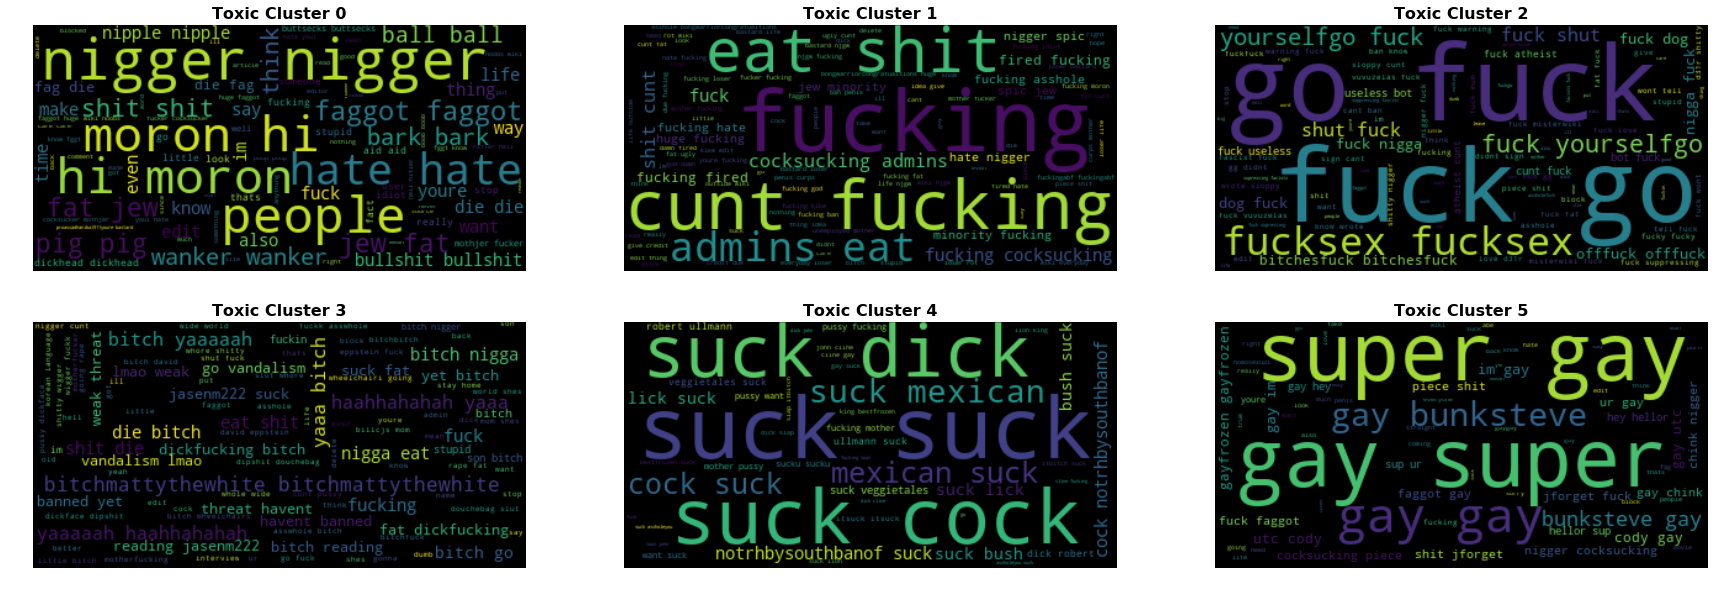

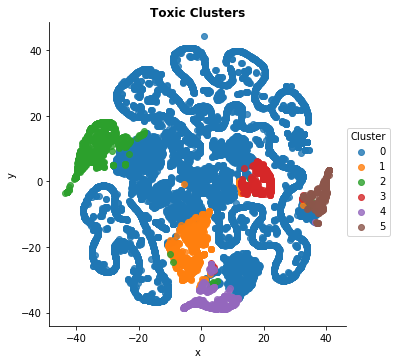

In [9]:
data = df_t.comment_text_clean
n_clusters = 6
tag = 'Toxic'
ncols = 3

X_reduced = reduce_dimension(data, n_clusters)
X_reduced, labels = plot_kmc(X_reduced,n_clusters,tag)
wordcloud_visualizations(data,X_reduced,data,labels,n_clusters,ncols,tag)
_ = plot_tsne(X_reduced, labels, tag)

KMC saved at ../charts/kmc_Toxic.png
Inertia score: 4.514919039372154
Silhouette score: 0.2836693466512479
Cluster 0 has 1015 comments.
Cluster 1 has 964 comments.
Cluster 2 has 4155 comments.
Cluster 3 has 2081 comments.
Cluster 4 has 389 comments.
Cluster 5 has 7621 comments.
WordClouds saved at ../charts/wc_kmctsne_Toxic.png
T-SNE saved at ../charts/tsne_Toxic.png


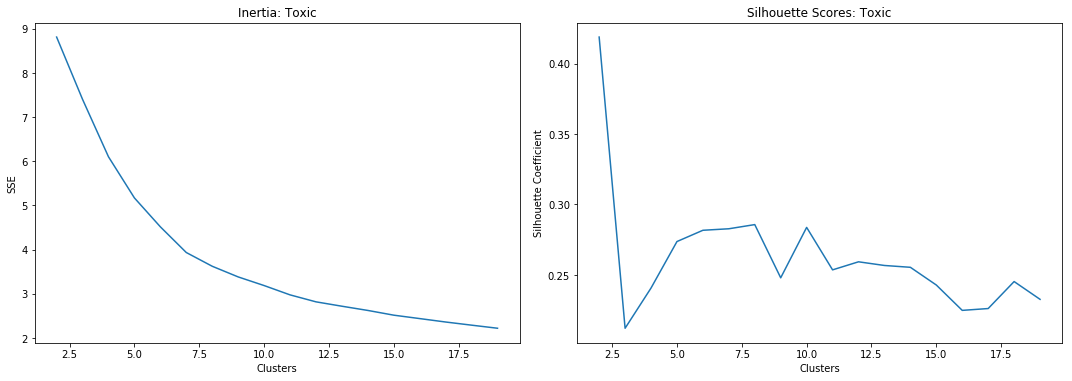

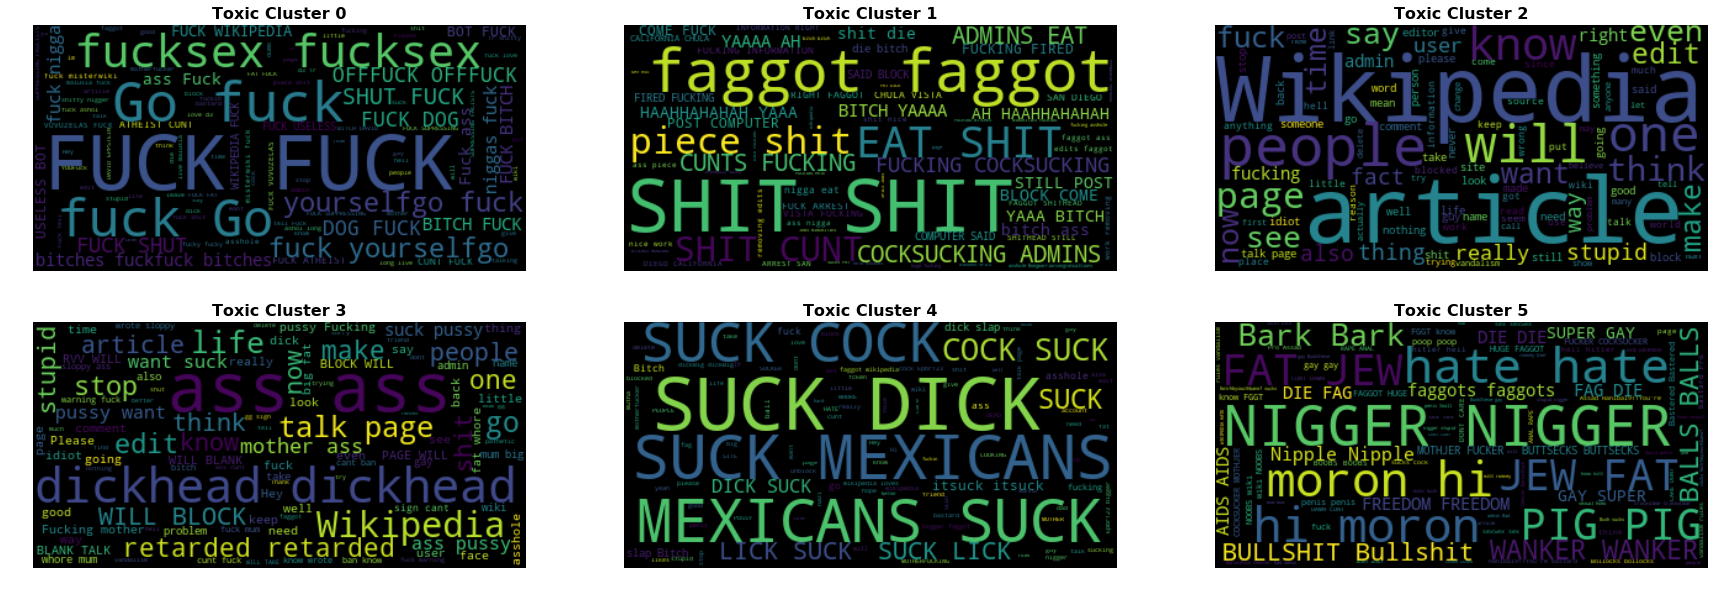

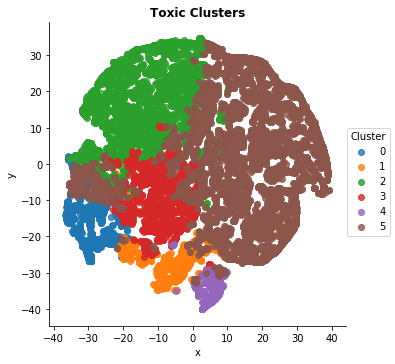

In [10]:
data = df_t.comment_text
n_clusters = 6
tag = 'Toxic'
ncols = 3

X_reduced = reduce_dimension(data, n_clusters)
X_reduced, labels = plot_kmc(X_reduced,n_clusters,tag)
wordcloud_visualizations(data,X_reduced,data,labels,n_clusters,ncols,tag)
_ = plot_tsne(X_reduced, labels, tag)

KMC saved at ../charts/kmc_Toxic.png
Inertia score: 4.3991643026860245
Silhouette score: 0.2822502745724405
Cluster 0 has 7384 comments.
Cluster 1 has 1020 comments.
Cluster 2 has 4424 comments.
Cluster 3 has 2051 comments.
Cluster 4 has 387 comments.
Cluster 5 has 959 comments.
WordClouds saved at ../charts/wc_kmctsne_Toxic.png
T-SNE saved at ../charts/tsne_Toxic.png


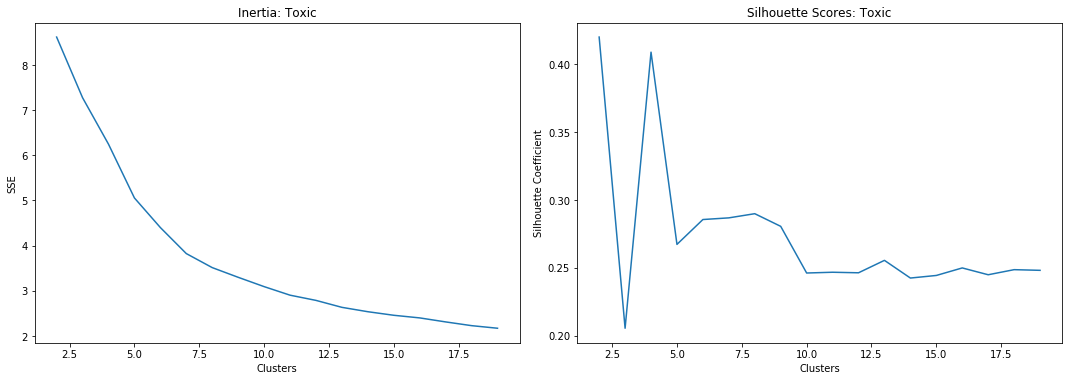

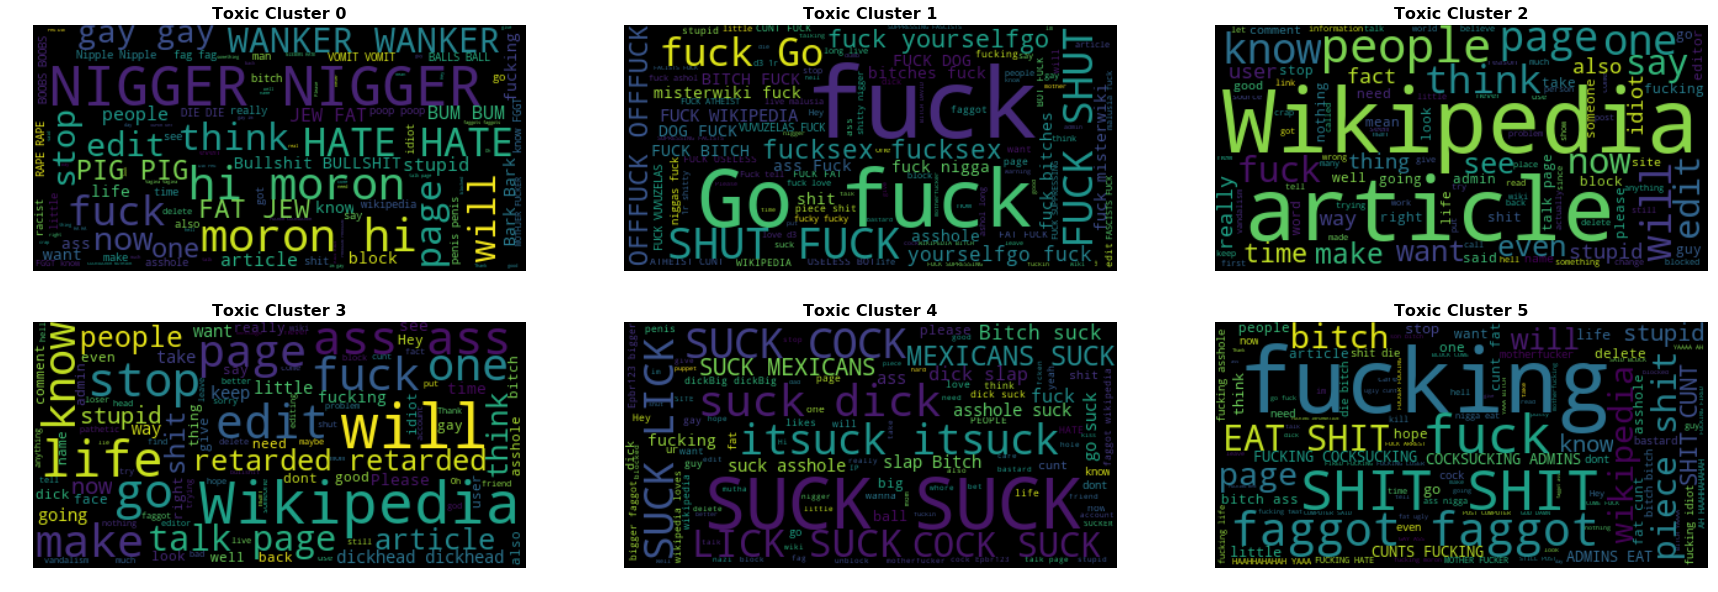

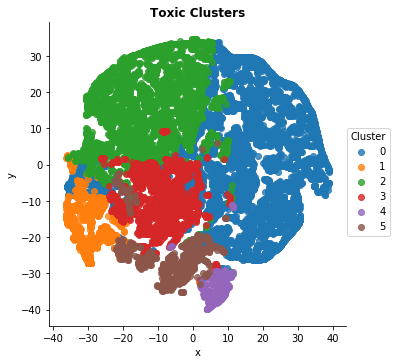

In [8]:
data = df_t.comment_text_s
n_clusters = 6
tag = 'Toxic'
ncols = 3

X_reduced = reduce_dimension(data, n_clusters)
X_reduced, labels = plot_kmc(X_reduced,n_clusters,tag)
wordcloud_visualizations(data,X_reduced,data,labels,n_clusters,ncols,tag)
_ = plot_tsne(X_reduced, labels, tag)

In [ ]:
data = df_nt.comment_text_clean
n_clusters = 6
tag = 'Clean'
ncols = 3

X_reduced = reduce_dimension(data, n_clusters)
X_reduced, labels = plot_kmc(X_reduced,n_clusters,tag)
wordcloud_visualizations(data,X_reduced,data,labels,n_clusters,ncols,tag)
_ = plot_tsne(X_reduced, labels, tag)

In [ ]:
data = df.comment_text_clean
n_clusters = 4
tag = 'All_Words'
ncols = 3

X_reduced = reduce_dimension(data, n_clusters)
X_reduced, labels = plot_kmc(X_reduced,n_clusters,tag)
wordcloud_visualizations(data,X_reduced,data,labels,n_clusters,ncols,tag)
_ = plot_tsne(X_reduced, labels, tag)

KMC saved at ../charts/kmc_Toxic.png
Inertia score: 5.407760245290074
Silhouette score: 0.23524192019081283
Cluster 0 has 959 comments.
Cluster 1 has 1677 comments.
Cluster 2 has 374 comments.
Cluster 3 has 3013 comments.
Cluster 4 has 5370 comments.
Cluster 5 has 306 comments.
Cluster 6 has 849 comments.
Cluster 7 has 3677 comments.
T-SNE saved at ../charts/tsne_Toxic.png


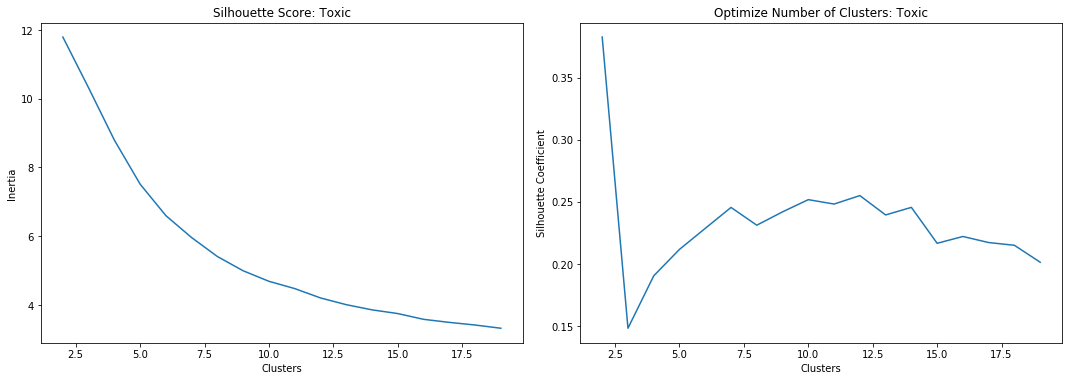

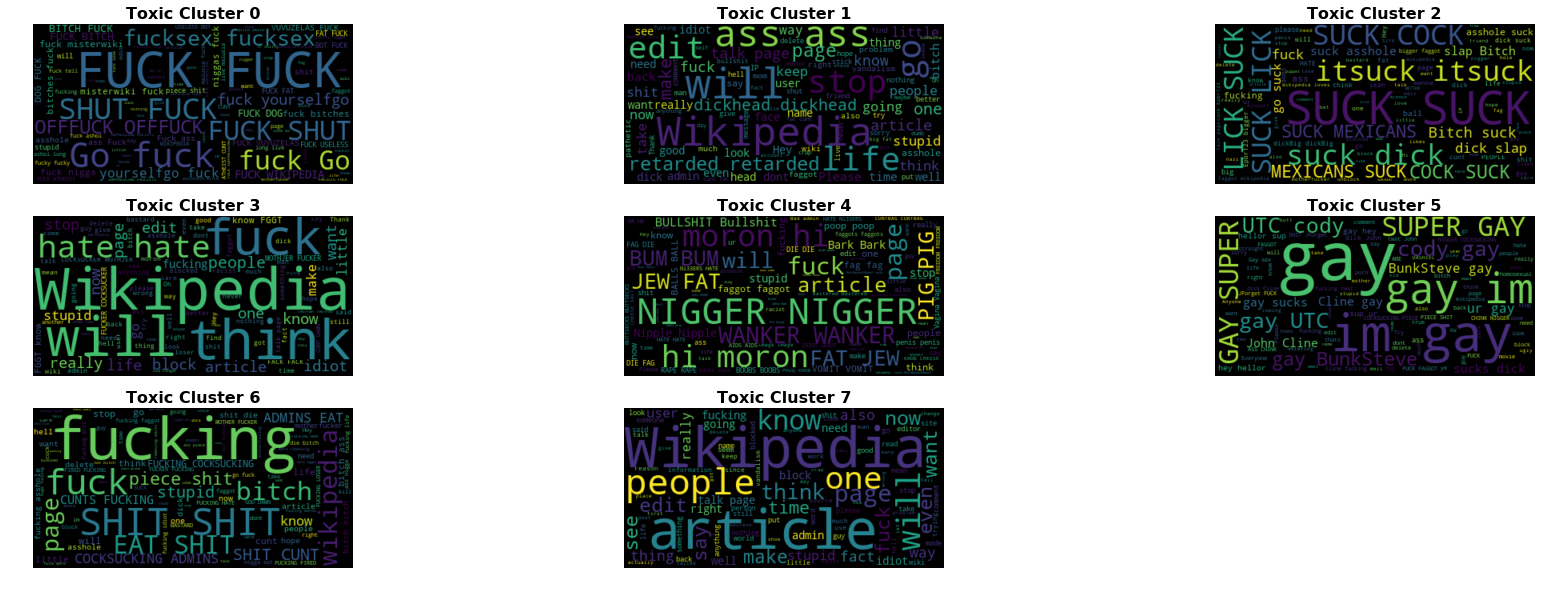

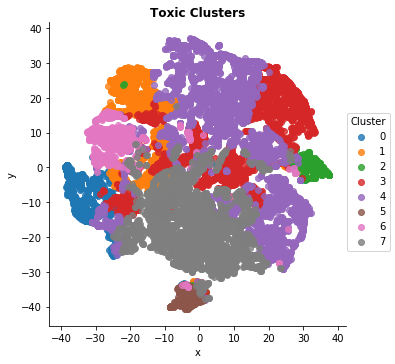

In [6]:
# helper functions broken out to troubleshoot
data = df_t.comment_text_s
n_clusters = 6
tag = 'Toxic'
ncols = 3

X_reduced = reduce_dimension(data, n_clusters)
X_reduced, labels = plot_kmc(X_reduced,n_clusters,tag)
wordcloud_visualizations(X_reduced,data,labels,n_clusters,ncols,tag)
_ = plot_tsne(X_reduced, labels, tag)

KMC saved at ../charts/kmc_Toxic.png
Inertia score: 4.836771698186017
Silhouette score: 0.2382904026581991
Cluster 0 has 5470 comments.
Cluster 1 has 1706 comments.
Cluster 2 has 868 comments.
Cluster 3 has 976 comments.
Cluster 4 has 3728 comments.
Cluster 5 has 3098 comments.
Cluster 6 has 379 comments.
T-SNE saved at ../charts/tsne_Toxic.png


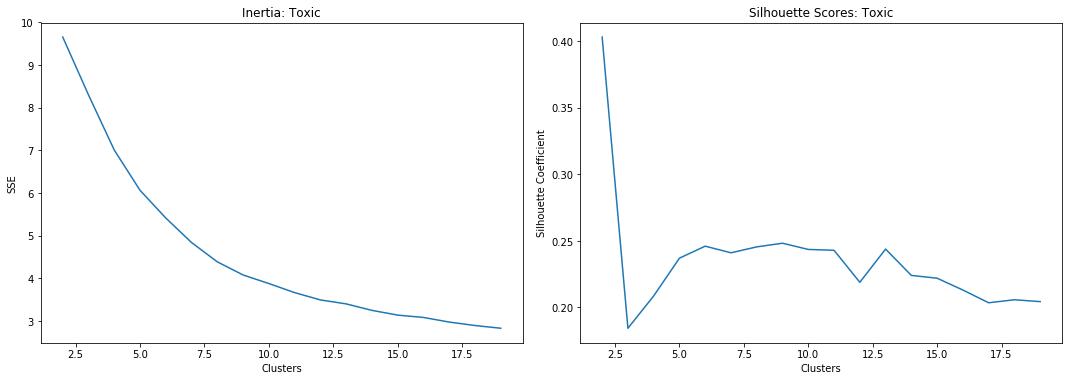

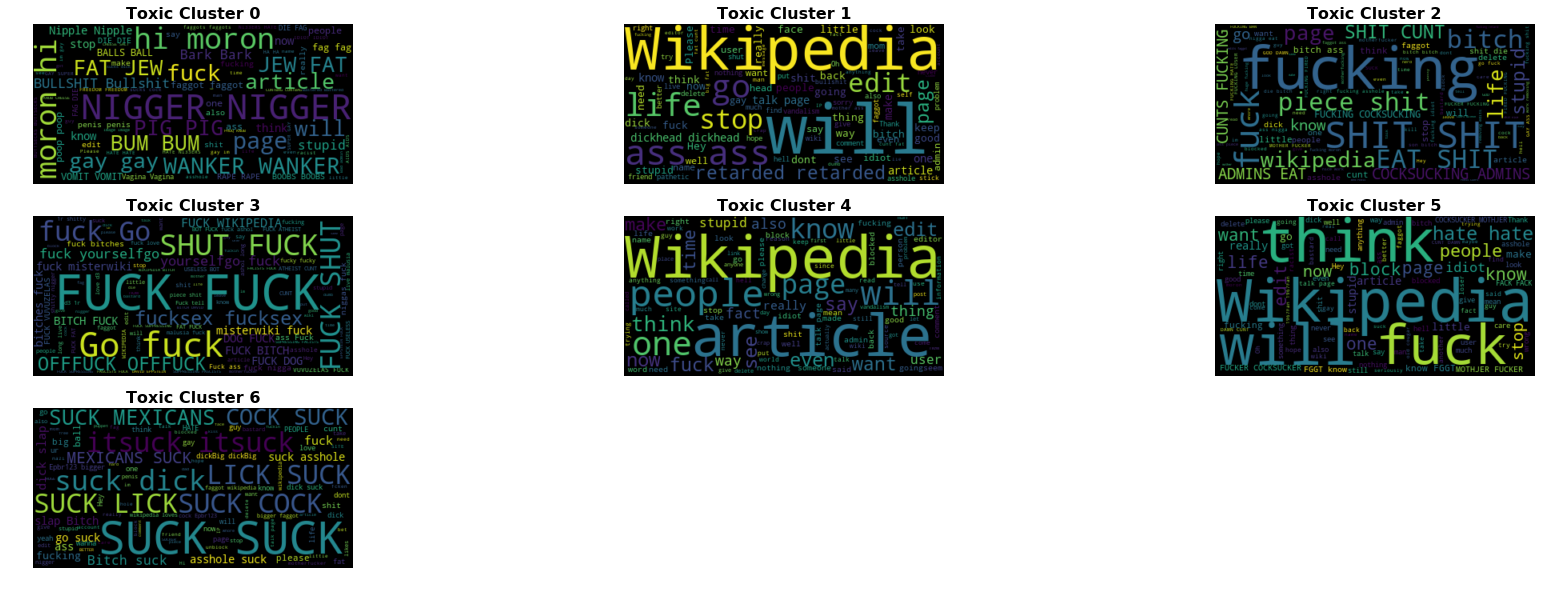

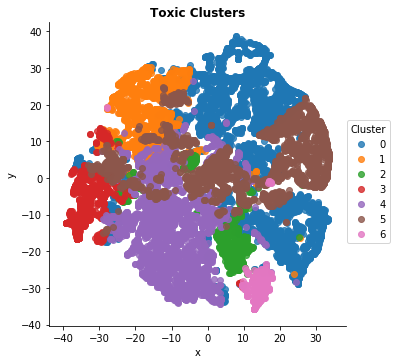

In [37]:
data = df_t.comment_text_s
n_clusters = 7
tag = 'Toxic'
ncols = 3

X_reduced = reduce_dimension(data, n_clusters)
X_reduced, labels = plot_kmc(X_reduced,n_clusters,tag)
wordcloud_visualizations(data,X_reduced,data,labels,n_clusters,ncols,tag)
_ = plot_tsne(X_reduced, labels, tag)

In [ ]:
df_t['cluster'] = labels
df_t.to_pickle('../data/df_t_cluster.pkl')

In [10]:
df_t.head()

id  \
idx                                  
3a4c7758fad18de3  3a4c7758fad18de3   
24d2b50726b67167  24d2b50726b67167   
c586b7a2fd575b13  c586b7a2fd575b13   
77d84b1321c22d9a  77d84b1321c22d9a   
1368c10281978876  1368c10281978876   

                                                       comment_text  toxic  \
idx                                                                          
3a4c7758fad18de3  , I hope your retarded kids get anal raped and...      1   
24d2b50726b67167  I am going to murder ZimZalaBim ST47 for being...      1   
c586b7a2fd575b13  Shut up you asswipe, we don't care. I'll decap...      1   
77d84b1321c22d9a  LGBT \n\nyou little fuck , are you a fag , tha...      1   
1368c10281978876  You're a stupid cunt \n\nFuck you dumb arse, y...      1   

                  severe_toxic  obscene  threat  insult  identity_hate  \
idx                                                                      
3a4c7758fad18de3             1        1       1       1              1   
24d2b50726b67167             1        1       1       1              1   
c586b7a2fd575b13             1        1       1       1              1   
77d84b1321c22d9a             1        1       1       1              1   
1368c10281978876             1        1       1       1              1   

                      category  rating   ...     \
idx                                      ...      
3a4c7758fad18de3  ToSTObThInIH       6   ...      
24d2b50726b67167  ToSTObThInIH       6   ...      
c586b7a2fd575b13  ToSTObThInIH       6   ...      
77d84b1321c22d9a  ToSTObThInIH       6   ...      
1368c10281978876  ToSTObThInIH       6   ...      

                                                  polarity_sentence  \
idx                                                                   
3a4c7758fad18de3  (-0.6, 1.0, -0.018750000000000003, [-0.4, -0.4...   
24d2b50726b67167                         (-1.0, -1.0, -1.0, [-1.0])   
c586b7a2fd575b13  (-0.2, 0.0, -0.07555555555555557, [0.0, -0.177...   
77d84b1321c22d9a  (-0.17750000000000005, 0.0, -0.088750000000000...   
1368c10281978876  (-0.41250000000000003, -0.41250000000000003, -...   

                 polarity_comment polarity_comment_s word_count char_count  \
idx                                                                          
3a4c7758fad18de3             0.00               0.00         94        494   
24d2b50726b67167             0.00               0.00         12         68   
c586b7a2fd575b13            -0.25              -0.25         24       3890   
77d84b1321c22d9a             0.00               0.00         56        280   
1368c10281978876             0.00               0.00         59        278   

                 char_count_s  polarity_min  polarity_max  polarity_mean  \
idx                                                                        
3a4c7758fad18de3          494       -0.6000        1.0000      -0.018750   
24d2b50726b67167           68       -1.0000       -1.0000      -1.000000   
c586b7a2fd575b13         1000       -0.2000        0.0000      -0.075556   
77d84b1321c22d9a          280       -0.1775        0.0000      -0.088750   
1368c10281978876          278       -0.4125       -0.4125      -0.412500   

                  cluster  
idx                        
3a4c7758fad18de3        0  
24d2b50726b67167        4  
c586b7a2fd575b13        4  
77d84b1321c22d9a        7  
1368c10281978876        3  

[5 rows x 25 columns]

KMC saved at ../charts/kmc_Clean.png
Inertia score: 5.155512324659611
Silhouette score: 0.38103921793411827
Cluster 0 has 34566 comments.
Cluster 1 has 107038 comments.
Cluster 2 has 1742 comments.


KeyboardInterrupt: 

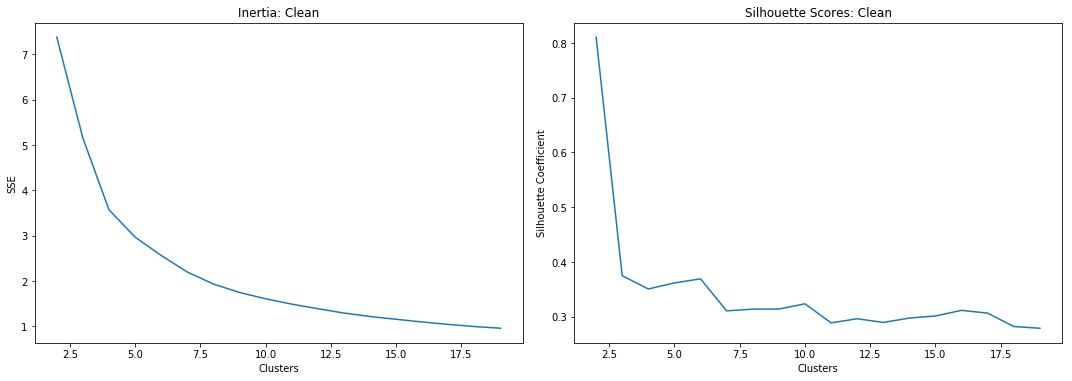

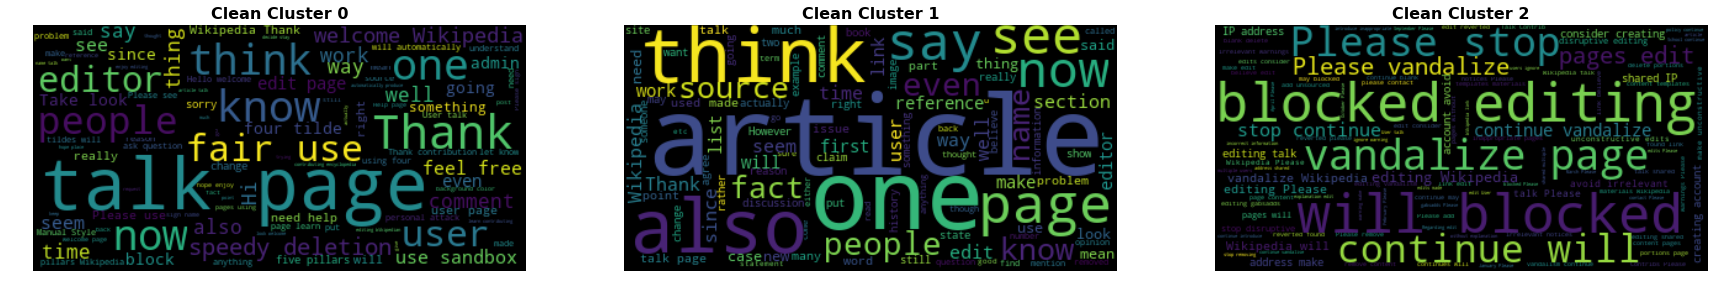

In [38]:
data = df_nt.comment_text_s
n_clusters = 3
tag = 'Clean'
ncols = 3

X_reduced = reduce_dimension(data, n_clusters)
X_reduced, labels = plot_kmc(X_reduced,n_clusters,tag)
wordcloud_visualizations(data,X_reduced,data,labels,n_clusters,ncols,tag)
_ = plot_tsne(X_reduced, labels, tag)

In [ ]:
data = df.comment_text_s
n_clusters = 4
tag = 'All_Words'
ncols = 3

X_reduced = reduce_dimension(data, n_clusters)
X_reduced, labels = plot_kmc(X_reduced,n_clusters,tag)
wordcloud_visualizations(data,X_reduced,data,labels,n_clusters,ncols,tag)
_ = plot_tsne(X_reduced, labels, tag)

In [ ]:
# data, n_clusters, seed, ncols,tag
# data = df.comment_text_s
# n_clusters = 10
# tag = 'All'
# create_kmc_tsne(data,n_clusters,seed,3,tag)